# People Detection and Crowd-sizing

Setup & Installs:

In [42]:
!pip -q install --upgrade ultralytics==8.3.40 kaggle opencv-python pandas==2.2.2 matplotlib seaborn

### import libraries

In [43]:
# All imports are done first
import os, random, zipfile, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab import files
from ultralytics import YOLO
import kagglehub

In [44]:
# Reproducibility
random.seed(42)
np.random.seed(42)

# GPU Check
import torch

print("CUDA working: ", torch.cuda.is_available())
print("GPU name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# Path Setups
root = Path("/content")
project_root = root / "people_detection"
data_root = project_root / "data"
image_exts = (".jpg", ".jpeg", ".png")

CUDA working:  True
GPU name:  Tesla T4


In [45]:
# Clean old subsets for safe reruns
if project_root.exists():
  print("Removing old subset")
  shutil.rmtree(project_root)
project_root.mkdir(parents = True, exist_ok = True)

Removing old subset


### Dataset Download & Subset Creation

In [46]:
download_path = kagglehub.dataset_download("adilshamim8/people-detection")

print("Path to dataset files:", download_path)

Using Colab cache for faster access to the 'people-detection' dataset.
Path to dataset files: /kaggle/input/people-detection


In [47]:
# Copy dataset into your project data directory
(project_root / "data").mkdir(parents=True, exist_ok=True)

target_splits = ['train', 'valid', 'test']

for split_name in target_splits:
    source_dir = Path(download_path) / split_name / split_name # Corrected to include nested split_name
    destination_dir = data_root / split_name

    if source_dir.exists():
        # Remove existing destination directory to ensure a fresh copy
        if destination_dir.exists():
            shutil.rmtree(destination_dir)
            print(f"Removed existing '{destination_dir}' for a fresh copy.")

        shutil.copytree(source_dir, destination_dir)
        print(f"Copied '{source_dir}' to '{destination_dir}'.")
    else:
        print(f"Source directory '{source_dir}' does not exist. Skipping.")


print("Dataset copied successfully")

Copied '/kaggle/input/people-detection/train/train' to '/content/people_detection/data/train'.
Copied '/kaggle/input/people-detection/valid/valid' to '/content/people_detection/data/valid'.
Copied '/kaggle/input/people-detection/test/test' to '/content/people_detection/data/test'.
Dataset copied successfully


#### Get subset of data

In [48]:
# Get a subset with 20% of the data with maximum images set to 3000
def collect_images(base: Path):
  return sorted([p for p in base.rglob("*") if p.suffix.lower() in image_exts])

train_images = collect_images(data_root / "train")
print(f"Total images found: {len(train_images)}")

Total images found: 15210


In [49]:
subset_fraction = 0.20
n_target = int(len(train_images) * subset_fraction)
n_max = 3000
n_subset = min(n_target, n_max)
print(f"Using {n_subset} images (20% of the total data, capped at {n_max})")

subset_images = random.sample(train_images, n_subset)
random.shuffle(subset_images)
split_idx = int(len(subset_images) * 0.8)
subset_train_images = subset_images[:split_idx]
subset_val_images = subset_images[split_idx:]
print(f"Subset split: {len(subset_train_images)} train / {len(subset_val_images)} val")


Using 3000 images (20% of the total data, capped at 3000)
Subset split: 2400 train / 600 val


In [50]:
subset_data_path = data_root / "subset"
subset_data_path.mkdir(parents = True, exist_ok = True)

images_train = subset_data_path / "images/train"
images_val = subset_data_path / "images/val"
labels_train = subset_data_path / "labels/train"
labels_val = subset_data_path / "labels/val"

for p in [images_train, images_val, labels_train, labels_val]:
  p.mkdir(parents = True, exist_ok = True)

def safe_link(src: Path, dst: Path):
  try:
    os.symlink(src, dst)
  except:
    shutil.copy(src, dst)

for img in subset_train_images:
  safe_link(img, images_train / img.name)

for img in subset_val_images:
  safe_link(img, images_val / img.name)

print("Subset images copied")

Subset images copied


#### Pseudo-Label Generation (YOLOv8n)
- generate annotations using pretrained model

In [51]:
# Generate pseudo labels using pretrained YOLOv8n
train_labels = list(labels_train.glob("*.txt"))
val_labels = list(labels_val.glob("*.txt"))
print(f"Train labels: {len(train_labels)}")
print(f"Val labels: {len(val_labels)}")

if len(train_labels) == 0 and len(val_labels) == 0:
    print("No labels found. YOLOv8n will generate pseudo labels.")
    base_model = YOLO("yolov8n.pt")

    def pseudo_label_stream(model, img_folder: Path, label_folder: Path, conf=0.35, iou=0.5, imgsz=640):
      label_folder.mkdir(parents = True, exist_ok = True)

      results = model.predict(
          source = str(img_folder),
          imgsz = imgsz,
          conf = conf,
          iou = iou,
          stream = True,
          verbose = False,
          max_det = 200
      )

      n_files = 0
      for r in results:
        img_path = Path(r.path)
        h, w = r.orig_shape
        lines = []

        if r.boxes is not None:
          for b in r.boxes:
            if int(b.cls.item()) != 0:
              continue

            x1, y1, x2, y2 = b.xyxy[0].tolist()
            cx = ((x1 + x2) / 2.0) / w
            cy = ((y1 + y2) / 2.0) / h
            bw = (x2 - x1) / w
            bh = (y2 - y1) / h
            lines.append(f"0 {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")

        if lines:
          label_path = label_folder / f"{img_path.stem}.txt"
          with open(label_path, "w") as f:
            f.write("\n".join(lines))
          n_files += 1

      print(f"Pseudo labels written in {label_folder}: {n_files}")

    pseudo_label_stream(base_model, images_train, labels_train)
    pseudo_label_stream(base_model, images_val, labels_val)
else:
  print("Pseudo labels already generated.")

print("Pseudo labeling done.")

Train labels: 0
Val labels: 0
No labels found. YOLOv8n will generate pseudo labels.
Pseudo labels written in /content/people_detection/data/subset/labels/train: 1965
Pseudo labels written in /content/people_detection/data/subset/labels/val: 500
Pseudo labeling done.


#### Create the training config

In [52]:
# Create data.yaml for this subset
data_yaml = subset_data_path / "people_subset.yaml"

data_yaml.write_text(
    f"path: {subset_data_path}\n"
    f"train: images/train\n"
    f"val: images/val\n"
    f"names:\n"
    f"  0: person\n"
)

print("data.yaml:\n", data_yaml.read_text())

data.yaml:
 path: /content/people_detection/data/subset
train: images/train
val: images/val
names:
  0: person



#### Hyperparameter Search (CFG1 vs CFG2)
- determine the best training parameters

In [53]:
# Hyperparameter search (2 configurations used, 8 and 10 epochs, YOLOv8n)
configurations = [
    {"name": "cfg1", "epochs": 8, "imgsz": 640, "lr0": 0.002},
    {"name": "cfg2", "epochs": 10, "imgsz": 768, "lr0": 0.0015},
]

runs_dir = project_root / "runs_people_yolo"
runs_dir.mkdir(parents=True, exist_ok=True)

hpo_rows = []
for cfg in configurations:
  print(f"\nRunning hyperparameter search for {cfg}")
  model = YOLO("yolov8n.pt")

  model.train(
      data = str(data_yaml),
      epochs = cfg["epochs"],
      imgsz = cfg["imgsz"],
      lr0 = cfg["lr0"],
      batch = 16,
      weight_decay = 0.0005,
      momentum = 0.937,
      hsv_h = 0.015,
      hsv_s = 0.7,
      hsv_v = 0.4,
      translate = 0.1,
      scale = 0.5,
      mosaic = 1.0,
      mixup = 0.1,
      project = str(runs_dir),
      name = cfg["name"],
      verbose = False
  )

  eval_results = model.val(
      data = str(data_yaml),
      imgsz = cfg["imgsz"],
      conf = 0.35,
      iou = 0.50,
      project = str(runs_dir),
      name = f"{cfg["name"]}_eval",
      verbose = False
  )

  try:
    P = float(eval_results.box.p.mean())
    R = float(eval_results.box.r.mean())
    mAP50 = float(eval_results.box.map50)
    map5095 = float(eval_results.box.map)
  except AttributeError:
    P = float(eval_results.results_dict.get("metrics/precision(B)", float("nan")))
    R = float(eval_results.results_dict.get("metrics/recall(B)", float("nan")))
    mAP50 = float(eval_results.results_dict.get("metrics/mAP50(B)", float("nan")))
    map5095 = float(eval_results.results_dict.get("metrics/mAP50-95(B)", float("nan")))

  F1 = 2 * P * R / (P + R + 1e-9)

  hpo_rows.append({
      "name": cfg["name"],
      "epochs": cfg["epochs"],
      "imgsz": cfg["imgsz"],
      "lr0": cfg["lr0"],
      "precision": P,
      "recall": R,
      "f1": F1,
      "mAP@0.5": mAP50,
      "mAP@0.5:0.95": map5095
  })




Running hyperparameter search for {'name': 'cfg1', 'epochs': 8, 'imgsz': 640, 'lr0': 0.002}
New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/people_detection/data/subset/people_subset.yaml, epochs=8, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/people_detection/runs_people_yolo, name=cfg1, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=No

train: Scanning /content/people_detection/data/subset/labels/train... 1965 images, 435 backgrounds, 0 corrupt: 100%|██████████| 2400/2400 [00:01<00:00, 1679.88it/s]

train: New cache created: /content/people_detection/data/subset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/people_detection/data/subset/labels/val... 500 images, 100 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<00:00, 1066.04it/s]

val: New cache created: /content/people_detection/data/subset/labels/val.cache


Plotting labels to /content/people_detection/runs_people_yolo/cfg1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.002' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/people_detection/runs_people_yolo/cfg1
Starting training for 8 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/8      2.38G      1.053       1.54      1.123         98        640: 100%|██████████| 150/150 [00:24<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.15it/s]


                   all        600       2108      0.749      0.736      0.796      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/8      2.42G      1.151      1.363      1.193        123        640: 100%|██████████| 150/150 [00:23<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  6.27it/s]


                   all        600       2108      0.724      0.667      0.751      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/8      2.39G      1.202      1.345       1.23         90        640: 100%|██████████| 150/150 [00:22<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.63it/s]

                   all        600       2108      0.741      0.634      0.732      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/8      2.38G      1.169      1.294      1.222         83        640: 100%|██████████| 150/150 [00:22<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.73it/s]

                   all        600       2108      0.805       0.73      0.829      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/8      2.39G      1.105      1.198      1.185        104        640: 100%|██████████| 150/150 [00:22<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.95it/s]

                   all        600       2108      0.806      0.749       0.85      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/8      2.28G      1.032      1.104      1.144        118        640: 100%|██████████| 150/150 [00:22<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.89it/s]

                   all        600       2108      0.825      0.769      0.869      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        7/8      2.41G     0.9988      1.051      1.132        132        640: 100%|██████████| 150/150 [00:22<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.75it/s]

                   all        600       2108       0.84      0.819        0.9      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        8/8      2.41G     0.9417      0.972      1.101         90        640: 100%|██████████| 150/150 [00:22<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.82it/s]

                   all        600       2108      0.862      0.809      0.909      0.739



8 epochs completed in 0.093 hours.
Optimizer stripped from /content/people_detection/runs_people_yolo/cfg1/weights/last.pt, 6.2MB
Optimizer stripped from /content/people_detection/runs_people_yolo/cfg1/weights/best.pt, 6.2MB

Validating /content/people_detection/runs_people_yolo/cfg1/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.09it/s]


                   all        600       2108      0.862      0.809      0.909      0.739
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/people_detection/runs_people_yolo/cfg1
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/people_detection/data/subset/labels/val.cache... 500 images, 100 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:04<00:00,  8.18it/s]


                   all        600       2108      0.868      0.832      0.881       0.75
Speed: 0.3ms preprocess, 3.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /content/people_detection/runs_people_yolo/cfg1_eval

Running hyperparameter search for {'name': 'cfg2', 'epochs': 10, 'imgsz': 768, 'lr0': 0.0015}
New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/people_detection/data/subset/people_subset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=768, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/people_detection/runs_people_yolo, name=cfg2, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=Tru

train: Scanning /content/people_detection/data/subset/labels/train.cache... 1965 images, 435 backgrounds, 0 corrupt: 100%|██████████| 2400/2400 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/people_detection/data/subset/labels/val.cache... 500 images, 100 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]


Plotting labels to /content/people_detection/runs_people_yolo/cfg2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0015' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 768 train, 768 val
Using 8 dataloader workers
Logging results to /content/people_detection/runs_people_yolo/cfg2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.15G     0.9201      1.771       1.08         45        768: 100%|██████████| 150/150 [00:32<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.27it/s]


                   all        600       2108      0.661      0.708      0.717       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.13G      1.125      1.546      1.217         36        768: 100%|██████████| 150/150 [00:30<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.46it/s]


                   all        600       2108      0.668      0.659      0.697      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.25G      1.194      1.472      1.283         28        768: 100%|██████████| 150/150 [00:30<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.80it/s]

                   all        600       2108      0.764      0.637       0.74      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.23G      1.132      1.314      1.236         71        768: 100%|██████████| 150/150 [00:30<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.70it/s]

                   all        600       2108      0.765      0.676      0.778      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.25G      1.075      1.205      1.199         45        768: 100%|██████████| 150/150 [00:30<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]

                   all        600       2108      0.767      0.699        0.8      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.25G      1.032      1.125      1.181         73        768: 100%|██████████| 150/150 [00:30<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.70it/s]

                   all        600       2108      0.789      0.729      0.826      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10       3.2G      0.973      1.029      1.139         47        768: 100%|██████████| 150/150 [00:30<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.74it/s]

                   all        600       2108      0.799      0.781      0.853      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.25G     0.8987     0.9418      1.102         57        768: 100%|██████████| 150/150 [00:30<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.82it/s]

                   all        600       2108      0.835      0.775       0.88      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.24G     0.8522     0.8696      1.073         36        768: 100%|██████████| 150/150 [00:30<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.90it/s]

                   all        600       2108      0.827      0.793      0.883      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.23G     0.7881     0.8075      1.042         33        768: 100%|██████████| 150/150 [00:30<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.89it/s]

                   all        600       2108      0.843      0.809      0.893       0.71



10 epochs completed in 0.130 hours.
Optimizer stripped from /content/people_detection/runs_people_yolo/cfg2/weights/last.pt, 6.2MB
Optimizer stripped from /content/people_detection/runs_people_yolo/cfg2/weights/best.pt, 6.2MB

Validating /content/people_detection/runs_people_yolo/cfg2/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.48it/s]


                   all        600       2108      0.842      0.809      0.893       0.71
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/people_detection/runs_people_yolo/cfg2
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/people_detection/data/subset/labels/val.cache... 500 images, 100 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:05<00:00,  7.13it/s]


                   all        600       2108       0.86      0.808      0.864      0.725
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /content/people_detection/runs_people_yolo/cfg2_eval


In [54]:
hpo_df = pd.DataFrame(hpo_rows)
print("\nHPO summary:\n", hpo_df)

best_row = hpo_df.sort_values("mAP@0.5", ascending=False).iloc[0]
print("\nBest configuration by mAP@0.5 was: \n", best_row)

best_name = best_row["name"]
best_imgsz = int(best_row["imgsz"])
best_run_dir = runs_dir / best_name
best_weights = best_run_dir / "weights" / "best.pt"


HPO summary:
    name  epochs  imgsz     lr0  precision    recall        f1   mAP@0.5  \
0  cfg1       8    640  0.0020   0.868252  0.831594  0.849528  0.881493   
1  cfg2      10    768  0.0015   0.860172  0.808349  0.833456  0.864275   

   mAP@0.5:0.95  
0      0.750195  
1      0.724980  

Best configuration by mAP@0.5 was: 
 name                cfg1
epochs                 8
imgsz                640
lr0                0.002
precision       0.868252
recall          0.831594
f1              0.849528
mAP@0.5         0.881493
mAP@0.5:0.95    0.750195
Name: 0, dtype: object


### Train Model
- Using the best model parameters

In [55]:
print("\nTrain with best weights:", best_weights)


Train with best weights: /content/people_detection/runs_people_yolo/cfg1/weights/best.pt


In [56]:
# Extended training, 20 epochs on best configuration

epochs = 20
name = "final_model"

model = YOLO(str(best_weights))

model.train(
    data = str(data_yaml),
    epochs = epochs,
    imgsz = best_imgsz,
    lr0 = float(best_row["lr0"]),
    batch = 16,
    weight_decay = 0.0005,
    momentum = 0.937,
    hsv_h = 0.015,
    hsv_s = 0.7,
    hsv_v = 0.4,
    translate = 0.1,
    scale = 0.5,
    mosaic = 1.0,
    mixup = 0.1,
    project = str(runs_dir),
    name = name,
    verbose = False
)

New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/people_detection/runs_people_yolo/cfg1/weights/best.pt, data=/content/people_detection/data/subset/people_subset.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/people_detection/runs_people_yolo, name=final_model, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=

train: Scanning /content/people_detection/data/subset/labels/train.cache... 1965 images, 435 backgrounds, 0 corrupt: 100%|██████████| 2400/2400 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/people_detection/data/subset/labels/val.cache... 500 images, 100 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]


Plotting labels to /content/people_detection/runs_people_yolo/final_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.002' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/people_detection/runs_people_yolo/final_model
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.36G     0.9446     0.9739      1.098         98        640: 100%|██████████| 150/150 [00:24<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.82it/s]

                   all        600       2108      0.804      0.776      0.856      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.41G      1.019      1.056      1.134        123        640: 100%|██████████| 150/150 [00:23<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.85it/s]

                   all        600       2108      0.786      0.769      0.836      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.41G      1.104      1.141       1.18         90        640: 100%|██████████| 150/150 [00:22<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.88it/s]

                   all        600       2108      0.754      0.655      0.756      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.38G      1.117      1.181      1.194         83        640: 100%|██████████| 150/150 [00:22<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.91it/s]

                   all        600       2108      0.768       0.72      0.796      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.39G      1.091      1.144       1.18        104        640: 100%|██████████| 150/150 [00:22<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.72it/s]

                   all        600       2108      0.763      0.746      0.816      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.28G      1.045      1.081      1.152        118        640: 100%|██████████| 150/150 [00:22<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.82it/s]

                   all        600       2108      0.792      0.738       0.83      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.41G       1.06      1.073      1.163        132        640: 100%|██████████| 150/150 [00:22<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.87it/s]

                   all        600       2108      0.801      0.762      0.854      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.41G      1.033      1.039      1.153         90        640: 100%|██████████| 150/150 [00:22<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.87it/s]

                   all        600       2108      0.827      0.733      0.842      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.42G      1.024      1.044       1.15        115        640: 100%|██████████| 150/150 [00:22<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.98it/s]

                   all        600       2108      0.815      0.805      0.876      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.46G      1.019      1.009      1.131        112        640: 100%|██████████| 150/150 [00:22<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.87it/s]

                   all        600       2108      0.822      0.796      0.878      0.677


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.24G     0.8975     0.9224      1.068         66        640: 100%|██████████| 150/150 [00:22<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.87it/s]

                   all        600       2108      0.836       0.79      0.881      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.27G     0.8684      0.858      1.054         38        640: 100%|██████████| 150/150 [00:22<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.86it/s]

                   all        600       2108      0.844      0.779      0.874      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.25G     0.8463     0.8376      1.043         47        640: 100%|██████████| 150/150 [00:22<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.89it/s]

                   all        600       2108      0.821      0.793      0.875      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.25G     0.8298     0.7977      1.037         47        640: 100%|██████████| 150/150 [00:22<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.81it/s]

                   all        600       2108      0.839        0.8      0.889      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.25G     0.8035     0.7701       1.03         56        640: 100%|██████████| 150/150 [00:22<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.71it/s]

                   all        600       2108      0.845      0.818      0.902      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.26G     0.7786     0.7177      1.008         32        640: 100%|██████████| 150/150 [00:22<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.77it/s]

                   all        600       2108      0.837      0.828      0.908      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.28G     0.7581     0.6982      1.003         62        640: 100%|██████████| 150/150 [00:22<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.96it/s]

                   all        600       2108       0.85      0.831      0.912      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.27G     0.7422     0.6884     0.9925         38        640: 100%|██████████| 150/150 [00:22<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.94it/s]

                   all        600       2108      0.863      0.833      0.916      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.27G     0.7218     0.6527     0.9845         46        640: 100%|██████████| 150/150 [00:22<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.98it/s]

                   all        600       2108      0.869      0.826      0.919       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.27G      0.697     0.6247     0.9678         73        640: 100%|██████████| 150/150 [00:22<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.98it/s]

                   all        600       2108      0.855      0.827      0.915      0.751



20 epochs completed in 0.179 hours.
Optimizer stripped from /content/people_detection/runs_people_yolo/final_model/weights/last.pt, 6.2MB
Optimizer stripped from /content/people_detection/runs_people_yolo/final_model/weights/best.pt, 6.2MB

Validating /content/people_detection/runs_people_yolo/final_model/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.14it/s]


                   all        600       2108       0.87      0.825      0.919       0.75
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/people_detection/runs_people_yolo/final_model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a9a7f36ee40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

- Evaluate model on validation set

In [57]:
eval = model.val(
    data = str(data_yaml),
    imgsz = best_imgsz,
    conf = 0.35,
    iou = 0.50,
    project = str(runs_dir),
    name = f"{name}_eval",
    verbose = False
)

try:
  P = float(eval.box.p.mean())
  R = float(eval.box.r.mean())
  mAP50 = float(eval.box.map50)
  map5095 = float(eval.box.map)
except AttributeError:
  P = float(eval.results_dict.get("metrics/precision(B)", float("nan")))
  R = float(eval.results_dict.get("metrics/recall(B)", float("nan")))
  mAP50 = float(eval.results_dict.get("metrics/mAP50(B)", float("nan")))
  map5095 = float(eval.results_dict.get("metrics/mAP50-95(B)", float("nan")))

F1 = 2 * P * R / (P + R + 1e-9)

print("\nExtended training results:")
print(f"Precision: {P:.4f}")
print(f"Recall: {R:.4f}")
print(f"F1: {F1:.3f}")
print(f"mAP@0.5: {mAP50:.4f}")
print(f"mAP@0.5:0.95: {map5095:.4f}")

best_model = model
best_run_dir = runs_dir / name

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/people_detection/data/subset/labels/val.cache... 500 images, 100 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:04<00:00,  8.01it/s]


                   all        600       2108      0.863      0.843      0.899      0.762
Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/people_detection/runs_people_yolo/final_model_eval

Extended training results:
Precision: 0.8626
Recall: 0.8435
F1: 0.853
mAP@0.5: 0.8986
mAP@0.5:0.95: 0.7619


#### Optimize counting performance

In [72]:
import torch
import gc
import os
torch.cuda.empty_cache()
gc.collect()

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [73]:
def chunked(lst, size):
    for i in range(0, len(lst), size):
        yield lst[i:i + size]

def clear_gpu():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

In [68]:
# Threshold sweep to optimize counting performance (YOLOv8n)
def load_label_counts(label_folder: Path):
  counts = {}

  for lf in label_folder.glob("*.txt"):
    with open(lf, "r") as f:
      lines = [ln.strip() for ln in f.readlines() if ln.strip()]
    counts[lf.stem] = len(lines)

  return counts

label_counts_val = load_label_counts(labels_val)
val_imgs = sorted([p for p in images_val.glob("*") if p.suffix.lower() in image_exts])
print(f"Validation images: {len(val_imgs)}, label files: {len(label_counts_val)}")

conf_list = [0.25, 0.30, 0.35, 0.40]
iou_list = [0.40, 0.50, 0.60]
rows = []

best_model.eval()
device = 0
chunk_size = 16

rows = []

for conf in conf_list:
    for iou in iou_list:

        preds = []

        with torch.no_grad():
            for batch in chunked(val_imgs, chunk_size):

                results = best_model.predict(
                    source=batch,
                    imgsz=best_imgsz,
                    conf=conf,
                    iou=iou,
                    device=device,
                    stream=False,
                    verbose=False,
                    max_det=200
                )

                for r in results:
                    name = Path(r.path).stem
                    n_pred = int((r.boxes.cls == 0).sum()) if r.boxes is not None else 0
                    n_true = label_counts_val.get(name, 0)
                    preds.append((n_true, n_pred))

                del results
                clear_gpu()

        df = pd.DataFrame(preds, columns=["true", "pred"])
        df["err"] = df["pred"] - df["true"]
        df["abs_err"] = df["err"].abs()
        df["sq_err"] = df["err"] ** 2

        rows.append({
            "conf": conf,
            "iou": iou,
            "MAE": df["abs_err"].mean(),
            "RMSE": np.sqrt(df["sq_err"].mean()),
            "Corr": df[["true", "pred"]].corr().iloc[0, 1],
        })

        clear_gpu()

sweep_df = pd.DataFrame(rows)
print(sweep_df.sort_values("MAE"))

Validation images: 600, label files: 500
    conf  iou       MAE      RMSE      Corr
10  0.40  0.5  0.706667  1.217922  0.954972
9   0.40  0.4  0.713333  1.220656  0.954270
6   0.35  0.4  0.721667  1.261613  0.955801
7   0.35  0.5  0.731667  1.279974  0.955668
11  0.40  0.6  0.735000  1.249667  0.953377
3   0.30  0.4  0.763333  1.392839  0.953930
8   0.35  0.6  0.765000  1.322246  0.954274
4   0.30  0.5  0.776667  1.415392  0.953779
5   0.30  0.6  0.833333  1.493318  0.950738
0   0.25  0.4  0.863333  1.574802  0.950577
1   0.25  0.5  0.885000  1.615034  0.950766
2   0.25  0.6  0.963333  1.713671  0.947520


## Model Evaluation

In [69]:
# Select best thresholds based on lowest MAE
best_mae = sweep_df.sort_values("MAE").iloc[0]

best_conf = float(best_mae["conf"])
best_iou  = float(best_mae["iou"])

print(f"Best thresholds selected → conf={best_conf}, IoU={best_iou}")

Best thresholds selected → conf=0.4, IoU=0.5


In [75]:

best_model.eval()
device = 0
chunk_size = 8   # SAFE for Colab T4/L4

final_preds = []

with torch.no_grad():
    for batch in chunked(val_imgs, chunk_size):

        results = best_model.predict(
            source=batch,
            imgsz=best_imgsz,
            conf=best_conf,
            iou=best_iou,
            device=device,
            stream=False,
            half=True,
            verbose=False,
            max_det=200
        )

        for r in results:
            name = Path(r.path).stem
            boxes = r.boxes
            n_pred = int((boxes.cls == 0).sum().item()) if boxes is not None else 0
            n_true = label_counts_val.get(name, 0)
            final_preds.append((n_true, n_pred))

        del results
        clear_gpu()

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
counts_df = pd.DataFrame(final_preds, columns=["true", "pred"])
counts_df["err"] = counts_df["pred"] - counts_df["true"]
counts_df["abs_err"] = counts_df["err"].abs()
counts_df["sq_err"] = counts_df["err"] ** 2

mae = counts_df["abs_err"].mean()
rmse = np.sqrt(counts_df["sq_err"].mean())
corr = counts_df[["true", "pred"]].corr().iloc[0, 1]

print("\nFinal counting metrics at tuned thresholds (YOLOv8n):")
print(f"Best conf = {best_conf}, best IoU = {best_iou}")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"Corr: {corr:.3f}")

print("\nDone. Best final model directory:", best_run_dir)


Final counting metrics at tuned thresholds (YOLOv8n):
Best conf = 0.4, best IoU = 0.5
MAE:  0.707
RMSE: 1.218
Corr: 0.955

Done. Best final model directory: /content/people_detection/runs_people_yolo/final_model


## Performance Metrics Visualization

Hyperparameter Search (HPO) Summary
   name  epochs  imgsz     lr0  precision    recall        f1   mAP@0.5  \
0  cfg1       8    640  0.0020   0.868252  0.831594  0.849528  0.881493   
1  cfg2      10    768  0.0015   0.860172  0.808349  0.833456  0.864275   

   mAP@0.5:0.95  
0      0.750195  
1      0.724980   



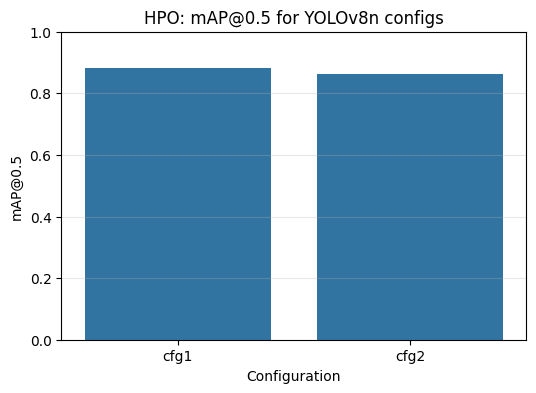

In [76]:

for var in ["hpo_df", "sweep_df", "counts_df"]:
  if var not in globals():
    raise RuntimeError(
        f"{var} is not defined. "
        "Make sure you have run the full training script above."
    )

print("Hyperparameter Search (HPO) Summary")
print(hpo_df, "\n")

# HPO: Bar chart of mAP@0.5 for cfg1 vs cfg2
plt.figure(figsize = (6, 4))
sns.barplot(data = hpo_df, x = "name", y = "mAP@0.5")
plt.title("HPO: mAP@0.5 for YOLOv8n configs")
plt.xlabel("Configuration")
plt.ylabel("mAP@0.5")
plt.ylim(0, 1.0)
plt.grid(axis = "y", alpha = 0.3)
plt.show()



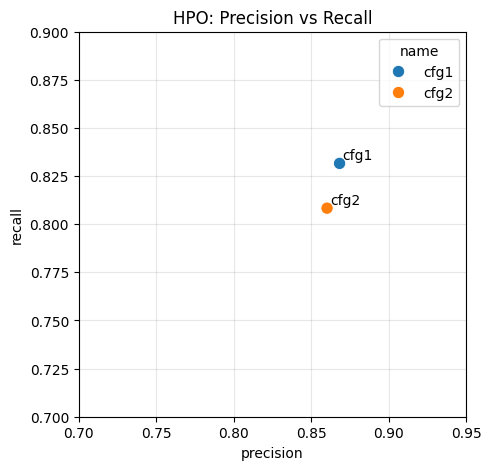

In [77]:
# HPO: Precision vs Recall scatter
plt.figure(figsize = (5, 5))
sns.scatterplot(data = hpo_df, x = "precision", y = "recall", hue = "name", s = 80)
for _, row in hpo_df.iterrows():
  plt.text(row["precision"] + 0.002, row["recall"] + 0.002, row["name"])
plt.xlim(0.7, 0.95)
plt.ylim(0.7, 0.9)
plt.title("HPO: Precision vs Recall")
plt.grid(True, alpha=0.3)
plt.show()

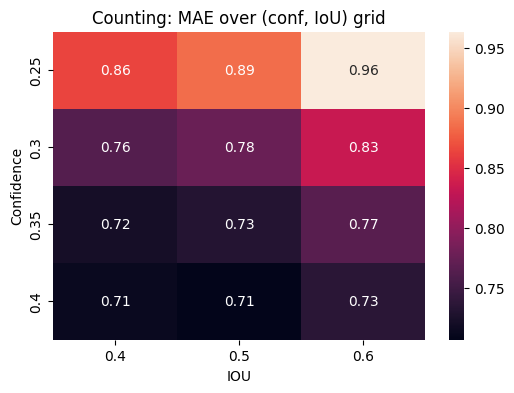

In [78]:
# Threshold sweep heatmap: MAE vs (conf, IoU)
pivot_mae = sweep_df.pivot(index = "conf", columns = "iou", values = "MAE")
plt.figure(figsize = (6, 4))
sns.heatmap(pivot_mae, annot = True, fmt = ".2f")
plt.title("Counting: MAE over (conf, IoU) grid")
plt.xlabel("IOU")
plt.ylabel("Confidence")
plt.show()

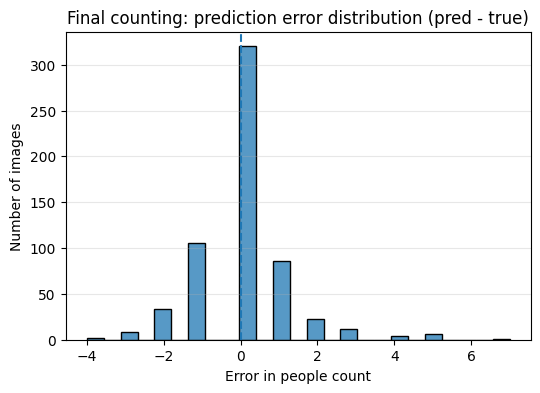

In [79]:
# Final counting metrics: error distribution histogram
plt.figure(figsize = (6, 4))
sns.histplot(counts_df["err"], bins = 25, kde = False)
plt.axvline(0, linestyle="--")
plt.title("Final counting: prediction error distribution (pred - true)")
plt.xlabel("Error in people count")
plt.ylabel("Number of images")
plt.grid(axis="y", alpha=0.3)
plt.show()


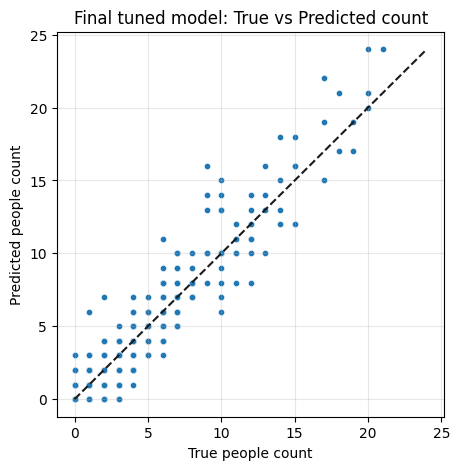

Metrics & graphs cell finished


In [80]:
# Final counting: True vs Pred scatter
plt.figure(figsize = (5, 5))
sns.scatterplot(data = counts_df, x = "true", y = "pred", s = 20)
max_count = int(max(counts_df["true"].max(), counts_df["pred"].max()))
plt.plot([0, max_count], [0, max_count], "k--")
plt.xlabel("True people count")
plt.ylabel("Predicted people count")
plt.title("Final tuned model: True vs Predicted count")
plt.grid(True, alpha=0.3)
plt.show()

print("Metrics & graphs cell finished")

In [82]:
## load the best model
best_run_dir = runs_dir / "final_model"
# model = YOLO(best_run_dir / 'weights/best.pt')


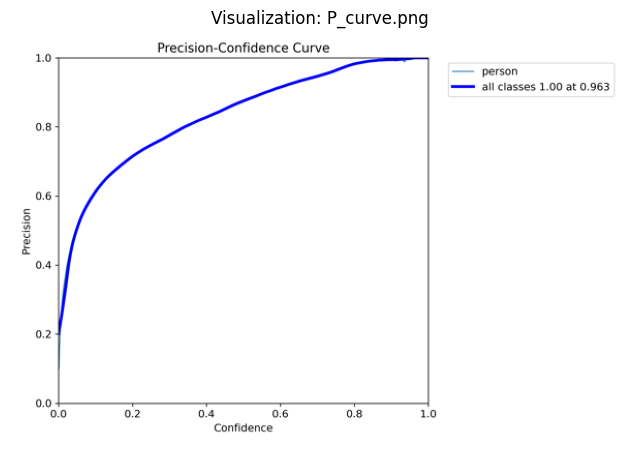

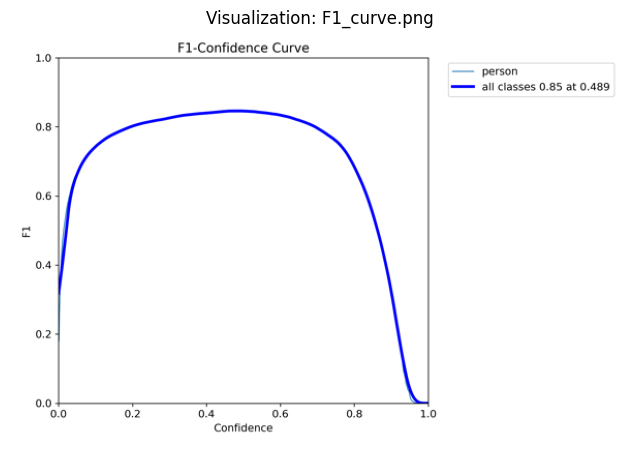

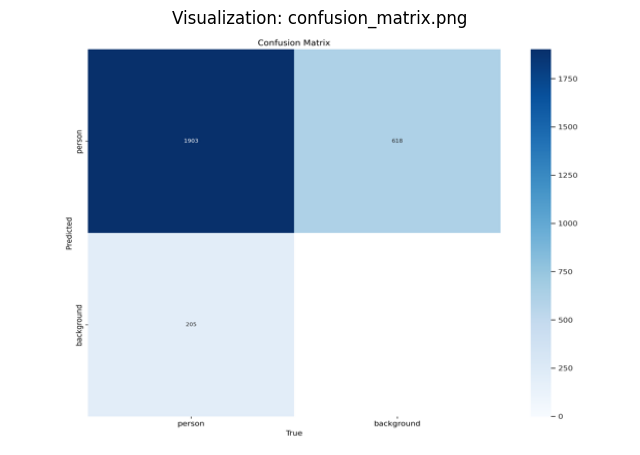

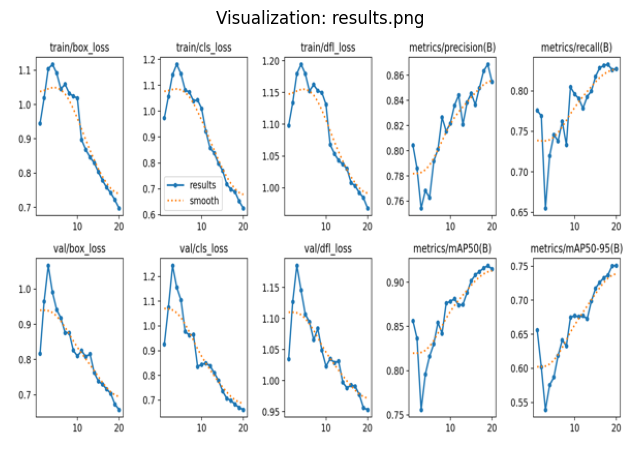

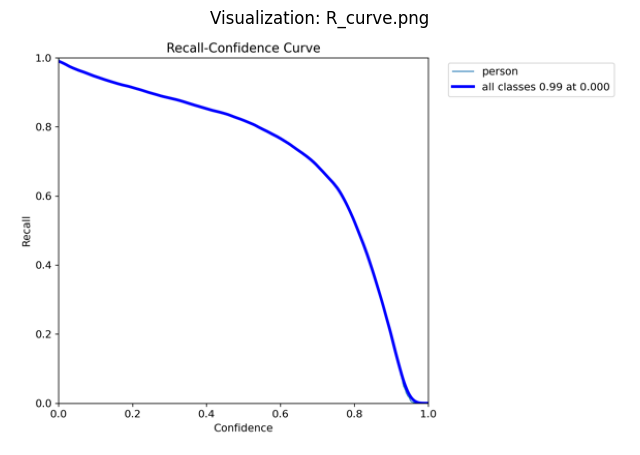

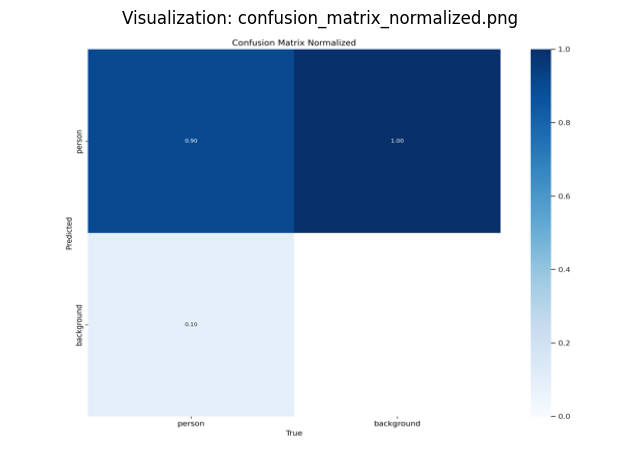

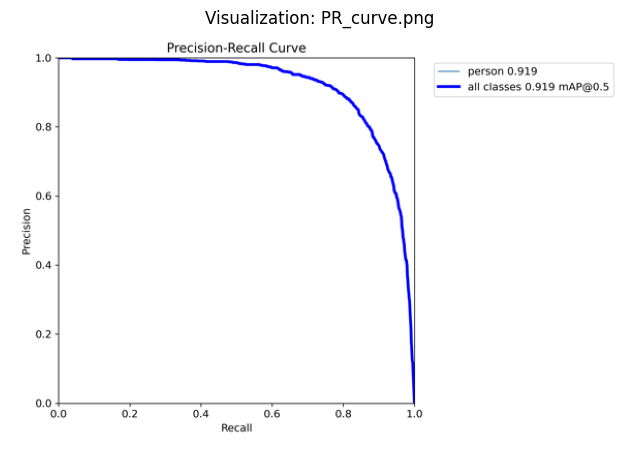

In [83]:
# loop through result visualization images
import matplotlib.pyplot as plt
from PIL import Image
png_files = [f for f in os.listdir(best_run_dir) if f.endswith(".png")]

# Loop through each .png file and display it
for png_file in png_files:
    file_path = os.path.join(best_run_dir, png_file)
    image = Image.open(file_path).resize((600, 400))
    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    plt.title(f"Visualization: {png_file}")
    plt.show()